# Beginning Work on Twitter Disaster Kaggle Competition

In [159]:
import nltk
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
import gensim
import gensim.downloader as gensim_api
import warnings
warnings.filterwarnings("ignore")

Below we will define a function that takes in a column with raw text data and returns a cleaned version of that column

In [160]:
train = pd.read_csv("..\\data\\test.csv")
test = pd.read_csv("..\\data\\train.csv")

In [161]:
train.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [162]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


Things to notice is that the size of our dataframe is 3263 but there are only 3237 non-null values and 2158 for keyword and location respectively

In [163]:
train.keyword.unique() # notice NaN is a keyword

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [164]:
train.location.unique() # again here NaN is a location

array([nan, 'London', "Niall's place | SAF 12 SQUAD |", ...,
       'Acey mountain islanddåÇTorontoåÈ', 'los angeles',
       'Brussels, Belgium'], dtype=object)

Eventually we will need to figure out what to do with these missing values, but for now lets focus on cleaning up the text!

In [165]:
train.id.unique() # no repeating ids which is good

array([    0,     2,     3, ..., 10868, 10874, 10875], dtype=int64)

In [166]:
train.columns

Index(['id', 'keyword', 'location', 'text'], dtype='object')

Found a list of contractions from a stack overflow post. This dictionary will be used to convert contractions to their root words.

In [167]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

# This function will be used to do 4 things at once:
 1) it will turn any contractions that appear above into their respected root words i.e "won't" will become "will not"

2) It will use a regular expression to remove any unwanted characters from our text. In this case unwanted characters are punctuation and any special characters sucha as '@'

3) It will remove any stop words that appear in our text. Here the stop words were pulled from a pre-defined list of stopwords from NLTK

4) Lastly it will tokenize our text. Tokenization is the process of taking a body of text and converting it into lists of strings.

In [168]:
def clean_text(text, remove_stopwords = False):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''

    # Convert words to lower case
    text = text.lower()

    # removing non-ascii characters
    new_val = text.encode("ascii", "ignore")
    text = new_val.decode()

    # Replace contractions with their longer forms
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)

    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE) # removes website links
    text = re.sub(r'\<a href', ' ', text) # removed HTML tags
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)

    # remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english")) # pulli-ng a list of stopwords from NLTK
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)

    return text

In [169]:
train['text_cleaned'] = list(map(clean_text, train.text))
test['text_cleaned'] = list(map(clean_text, test.text))

In [170]:
train['text_cleaned_str'] = train['text_cleaned'].apply(lambda x: " ".join(x) )
test['text_cleaned_str'] = test['text_cleaned'].apply(lambda x: " ".join(x) )

# Lemmatizing is the process of taking a word like swimming and converting it to its dictionary root word. So swimming becomes swim, eating becomes eat. Swam becomes swim. For more information click here:
https://towardsdatascience.com/lemmatization-in-natural-language-processing-nlp-and-machine-learning-a4416f69a7b6

In [171]:
def lemmatized_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda word:list(map(lemm.lemmatize, word)),
                                     df.text_cleaned))

In [172]:
lemmatized_words(train)
lemmatized_words(test)

In [173]:
train["text_lemm_str"]=train["lemmatized_text"].apply(lambda x: " ".join(x) )
test["text_lemm_str"]=test["lemmatized_text"].apply(lambda x: " ".join(x) )

In [174]:
from collections import Counter
train["hashtag_count"] = train["text"].apply(lambda x: x.count("#"))

In [175]:
train.drop(columns = ["text_cleaned", "lemmatized_text"], inplace = True)
test.drop(columns = ["text_cleaned", "lemmatized_text"], inplace = True)

In [176]:
train.head()  #ntoice our new dataframe has two new columns text_cleaned and lemmatized_text

,id,keyword,location,text,text_cleaned_str,text_lemm_str,hashtag_count
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash,just happened a terrible car crash,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard about earthquake is different cities sta...,heard about earthquake is different city stay ...,1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...,there is a forest fire at spot pond goose are ...,0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,apocalypse lighting spokane wildfire,2
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 in china and taiwan,typhoon soudelor kill 28 in china and taiwan,0


In [177]:
train.loc[train.text.str.find('fuck') > 0] # we will use these explicit words to add an additional column to our dataframe

,id,keyword,location,text,text_cleaned_str,text_lemm_str,hashtag_count
231,750,avalanche,NaN,if this fucking is true i will be decapitated ...,if this fucking is true i will be decapitated ...,if this fucking is true i will be decapitated ...,0
290,937,blaze,"Cleveland, OH",I never got paid to give a fuck..we might as w...,i never got paid to give a fuck we might as we...,i never got paid to give a fuck we might a wel...,0
344,1115,blew%20up,"Coos Bay, OR",We were fucking around on Google maps at work ...,we were fucking around on google maps at work ...,we were fucking around on google map at work a...,0
353,1140,blight,NaN,@colemcfadyean fuck off cole ??????,colemcfadyean fuck off cole,colemcfadyean fuck off cole,0
377,1210,blizzard,That place,If blizzard did another 12 month sub thing and...,if blizzard did another 12 month sub thing and...,if blizzard did another 12 month sub thing and...,0
411,1330,blown%20up,Scout Team,If you bored as shit don't nobody fuck wit you...,if you bored as shit do not nobody fuck wit yo...,if you bored a shit do not nobody fuck wit you...,0
414,1339,blown%20up,somewhere or other,I don't understand how White Iverson by Post M...,i do not understand how white iverson by post ...,i do not understand how white iverson by post ...,0
481,1564,bomb,shanghai,Bruh this sex on the beach??is bomb as fuck yo,bruh this sex on the beach is bomb as fuck yo,bruh this sex on the beach is bomb a fuck yo,0
584,1902,burning,daily ? 18 ? ?,RT: A real burn book entry about CA: why the f...,rt a real burn book entry about ca why the fuc...,rt a real burn book entry about ca why the fuc...,0
666,2168,catastrophic,NaN,If a å£1 rise in wages is going to have such a...,if a 1 rise in wages is going to have such a c...,if a 1 rise in wage is going to have such a ca...,0


In [192]:
test

,id,keyword,location,text,target,text_cleaned_str,text_lemm_str
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,our deed are the reason of this earthquake may...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,all resident asked to shelter in place are bei...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive wildfires evacuation ord...,13 000 people receive wildfire evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,just got sent this photo from ruby alaska a sm...
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...,two giant crane holding a bridge collapse into...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,aria ahrary thetawniest the out of control wil...,aria ahrary thetawniest the out of control wil...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m1 94 01 04 utc 5km s of volcano hawaii,m1 94 01 04 utc 5km s of volcano hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating after an e bike collided ...,police investigating after an e bike collided ...


## That was some basic cleaning, lemmatizing, and tokenizing: Now let us try to prepare our model

In [178]:
# Create a Vectorizer Object
vectorizer = CountVectorizer()

vectorizer.fit(train.text_cleaned_str)

# Printing the identified Unique words along with their indices
print("Vocabulary: ", vectorizer.vocabulary_)

# Encode the Document
X_count = vectorizer.transform(test.text)

# Summarizing the Encoded Texts
print("Encoded Document is:")
print(X_count.toarray())

Vocabulary:  {'just': 4730, 'happened': 3924, 'terrible': 8634, 'car': 1642, 'crash': 2225, 'heard': 3998, 'about': 373, 'earthquake': 2848, 'is': 4522, 'different': 2587, 'cities': 1890, 'stay': 8268, 'safe': 7504, 'everyone': 3094, 'there': 8719, 'forest': 3449, 'fire': 3348, 'at': 853, 'spot': 8192, 'pond': 6689, 'geese': 3634, 'are': 770, 'fleeing': 3390, 'across': 415, 'the': 8677, 'street': 8336, 'cannot': 1620, 'save': 7573, 'them': 8704, 'all': 580, 'apocalypse': 725, 'lighting': 5101, 'spokane': 8182, 'wildfires': 9583, 'typhoon': 9097, 'soudelor': 8104, 'kills': 4824, '28': 152, 'in': 4345, 'china': 1837, 'and': 662, 'taiwan': 8534, 'we': 9470, 'shaking': 7756, 'it': 4542, 'an': 653, 'they': 8734, 'would': 9692, 'probably': 6816, 'still': 8300, 'show': 7855, 'more': 5707, 'life': 5092, 'than': 8666, 'arsenal': 795, 'did': 2577, 'yesterday': 9784, 'eh': 2909, 'hey': 4052, 'how': 4204, 'you': 9795, 'what': 9534, 'nice': 5962, 'hat': 3955, 'fuck': 3542, 'off': 6147, 'no': 6003, 

# Now that we have used a count vectorizer to transformn our corpus let us try to use a TF-ID

In [180]:
vectorizer = TfidfVectorizer()

vectorizer.fit(train.text_cleaned_str)

X_tfid = vectorizer.transform(test.text)

vectorizer.get_feature_names_out()


print(X_tfid.shape)

y =  test[["target"]]

(7613, 9850)


In [182]:
# Classifers to test
classifiers = {
    'kNN': KNeighborsClassifier(n_neighbors = 11),
    'Logit':LogisticRegression(),
    'Tree': DecisionTreeClassifier(),
    'Bayes': MultinomialNB(),
    'SVM' : SVC()
}

scores_count = {} # Store cross-validation results in a dictionary
for classifier in classifiers:
    scores_count[classifier] = cross_validate( # perform cross-validation
        classifiers[classifier], # classifier object
        X_count, # feature matrix
        y, # gold labels
        cv=10, #number of folds
        scoring=['precision', 'accuracy', 'recall', 'f1'] # scoring methods
    )

# Lets try the same approach but with the tfid vectorizer

In [183]:
# Classifers to test
classifiers = {
    'kNN': KNeighborsClassifier(n_neighbors = 11),
    'Logit':LogisticRegression(),
    'Tree': DecisionTreeClassifier(),
    'Bayes': MultinomialNB(),
    'SVM' : SVC()
}

scores_tfid = {} # Store cross-validation results in a dictionary
for classifier in classifiers:
    scores_tfid[classifier] = cross_validate( # perform cross-validation
        classifiers[classifier], # classifier object
        X_tfid, # feature matrix
        y, # gold labels
        cv=10, #number of folds
        scoring=['precision', 'accuracy', 'recall', 'f1'] # scoring methods
    )

In [184]:
# Examine the performance of our simple classifiers

def compare_scores(scores_dict):
    '''
    Takes a dictionary of cross_validate scores.
    Returns a color-coded Pandas dataframe that summarizes those scores.
    '''
    df = pd.DataFrame(scores_dict).T.applymap(np.mean).style.background_gradient(cmap='RdYlGn')
    return df
# Compare cross-validation scores

In [185]:
compare_scores(scores_count) # used count vectorizer

,fit_time,score_time,test_precision,test_accuracy,test_recall,test_f1
kNN,0.007547,0.401394,0.733991,0.583606,0.049528,0.091100
Logit,0.591294,0.009961,0.619614,0.661638,0.553653,0.581400
Tree,1.668869,0.009471,0.546847,0.604631,0.544807,0.542835
Bayes,0.003890,0.005997,0.654266,0.702355,0.650864,0.650097
SVM,9.506418,0.913976,0.756649,0.722057,0.522469,0.615273


In [186]:
compare_scores(scores_tfid) # used TF-ID vectorizer

,fit_time,score_time,test_precision,test_accuracy,test_recall,test_f1
kNN,0.007699,0.361699,0.772739,0.637194,0.219171,0.336234
Logit,0.208181,0.013246,0.708116,0.709183,0.549984,0.616367
Tree,1.699779,0.007984,0.528329,0.590834,0.494644,0.509616
Bayes,0.006261,0.010113,0.720454,0.720353,0.568019,0.632053
SVM,11.411482,1.103188,0.733163,0.709445,0.512678,0.599494


SO from this we can see that our count vectorizer without removing stop words is giving us a better f1 score than our TFID vectorizer.

# Our modeling scores show that we should focus on a naive bayes as our model of choice

In [187]:
# Create a Vectorizer Object
vectorizer = CountVectorizer()

vectorizer.fit(train.text_cleaned_str)

# Printing the identified Unique words along with their indices
print("Vocabulary: ", vectorizer.vocabulary_)

# Encode the Document
X_count = vectorizer.transform(test.text)

# Summarizing the Encoded Texts
print("Encoded Document is:")
print(X_count.toarray())

Vocabulary:  {'just': 4730, 'happened': 3924, 'terrible': 8634, 'car': 1642, 'crash': 2225, 'heard': 3998, 'about': 373, 'earthquake': 2848, 'is': 4522, 'different': 2587, 'cities': 1890, 'stay': 8268, 'safe': 7504, 'everyone': 3094, 'there': 8719, 'forest': 3449, 'fire': 3348, 'at': 853, 'spot': 8192, 'pond': 6689, 'geese': 3634, 'are': 770, 'fleeing': 3390, 'across': 415, 'the': 8677, 'street': 8336, 'cannot': 1620, 'save': 7573, 'them': 8704, 'all': 580, 'apocalypse': 725, 'lighting': 5101, 'spokane': 8182, 'wildfires': 9583, 'typhoon': 9097, 'soudelor': 8104, 'kills': 4824, '28': 152, 'in': 4345, 'china': 1837, 'and': 662, 'taiwan': 8534, 'we': 9470, 'shaking': 7756, 'it': 4542, 'an': 653, 'they': 8734, 'would': 9692, 'probably': 6816, 'still': 8300, 'show': 7855, 'more': 5707, 'life': 5092, 'than': 8666, 'arsenal': 795, 'did': 2577, 'yesterday': 9784, 'eh': 2909, 'hey': 4052, 'how': 4204, 'you': 9795, 'what': 9534, 'nice': 5962, 'hat': 3955, 'fuck': 3542, 'off': 6147, 'no': 6003, 

# Time to fine tune our parameters

In [131]:
param_grid = {'alpha': list(np.arange(0, 1.1, .1))}

In [145]:
from sklearn.model_selection import RandomizedSearchCV


random_search = RandomizedSearchCV(MultinomialNB(), param_grid, cv=10, verbose=2, n_jobs=-1, n_iter=5)

random_search.fit(X_count, y);

Fitting 10 folds for each of 5 candidates, totalling 50 fits


In [146]:
random_search.best_params_

{'alpha': 1.0}

In [147]:
random_search.best_score_


0.693425731441914

In [148]:
results_NB = pd.DataFrame(random_search.cv_results_['params'])
results_NB['test_score'] = random_search.cv_results_['mean_test_score']

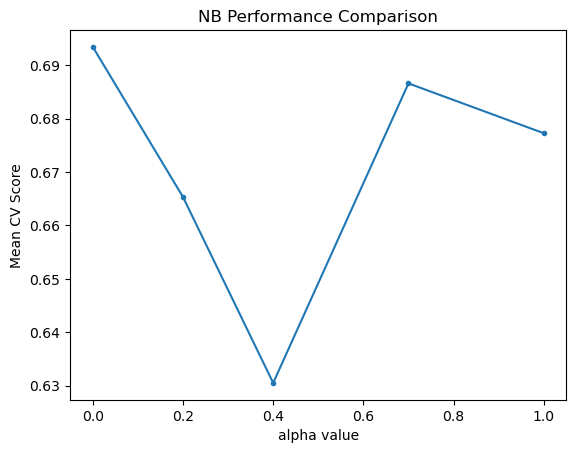

In [149]:
import matplotlib.pyplot as plt

plt.plot(results_NB['alpha'].sort_values(), results_NB['test_score'], marker = '.')
plt.xlabel('alpha value')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()

# Let us try to refit our model with our new alpha in mind

In [226]:
score_naive_bayes= {} # Store cross-validation results in a dictionary

score_naive_bayes['NaiveBayes'] = cross_validate( # perform cross-validation
MultinomialNB(alpha = .95, fit_prior= False),# classifier object
X_count, # feature matrix
y, # gold labels
cv=10, #number of folds
scoring=['precision', 'accuracy', 'recall', 'f1'] # scoring methods
)

In [227]:
compare_scores(score_naive_bayes)

,fit_time,score_time,test_accuracy,test_f1,test_precision,test_recall
NaiveBayes,0.014738,0.014252,0.693163,0.650509,0.634995,0.671043


In [228]:
clf = MultinomialNB(alpha = .95, fit_prior= False)# classifier object

clf.fit(X_count, y)

predictions = clf.predict(X_count)

clf.score(X_count, y)

0.8549848942598187

In [217]:
predictions = pd.DataFrame(predictions, columns = ['predicted_target'])

In [218]:
test_predicted = pd.concat([test, predictions], axis = 1)

In [219]:
test_predicted.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'text_cleaned_str',
       'text_lemm_str', 'predicted_target'],
      dtype='object')

In [220]:
test_predicted.loc[test_predicted.target == test_predicted.predicted_target]

,id,keyword,location,text,target,text_cleaned_str,text_lemm_str,predicted_target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,our deed are the reason of this earthquake may...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,all resident asked to shelter in place are bei...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive wildfires evacuation ord...,13 000 people receive wildfire evacuation orde...,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,just got sent this photo from ruby alaska a sm...,1
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...,two giant crane holding a bridge collapse into...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,aria ahrary thetawniest the out of control wil...,aria ahrary thetawniest the out of control wil...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m1 94 01 04 utc 5km s of volcano hawaii,m1 94 01 04 utc 5km s of volcano hawaii,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating after an e bike collided ...,police investigating after an e bike collided ...,1


vectorizer = TfidfVectorizer(stop_words= "english")

vectorizer.fit(train["text_cleaned_str"])

X = vectorizer.transform(test['text'])

print(X.shape)

y = test[["target"]]


scores3 = {} # Store cross-validation results in a dictionary

scores3['Bayes'] = cross_validate( # perform cross-validation
MultinomialNB(), # classifier object
X, # feature matrix
y, # gold labels
cv=10, #number of folds
scoring=['precision', 'accuracy', 'recall', 'f1'] # scoring methods
)

compare_scores(scores3)

# Time for a different apporach. Word Embeddings

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-sarcasm-twitter")

model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-base-finetuned-sarcasm-twitter")

def eval_conversation(text):

    input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')

    output = model.generate(input_ids=input_ids, max_length=3)

    dec = [tokenizer.decode(ids) for ids in output]

    label = dec[0]

    return label

# We will get 'normal' when sarcasm is not detected and 'derison' when detected


train["sarcasm"] =train.text_lower.apply(eval_conversation)

train